# Imports

In [51]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
import xgboost

# Data Cleaning

The shape of the mitbih_train is :  (87554, 188)
The shape of the mitbih_test is :  (21892, 188)
The last time value is :  1488.0


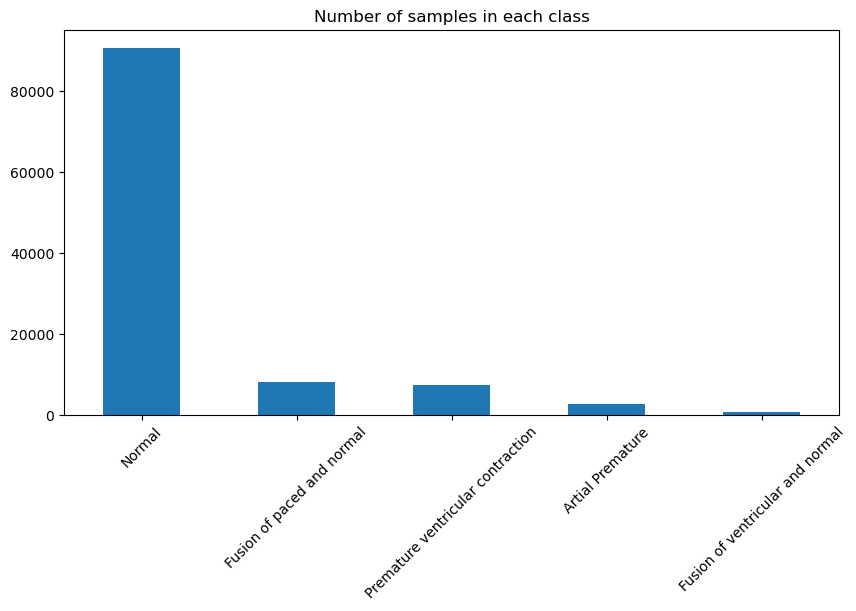

In [5]:
df_mitbih_train = pd.read_csv("mitbih_train.csv", header = None)
df_mitbih_test = pd.read_csv("mitbih_test.csv", header = None)

# print shapes of the dataframes
print("The shape of the mitbih_train is : ", df_mitbih_train.shape)
print("The shape of the mitbih_test is : ", df_mitbih_test.shape)

df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
#df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_mitbih.shape[1] - 1 
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_mitbih.columns = list(time) + ["label"]

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_mitbih["label"].value_counts()
# substitute the class names
counts.index = counts.index.map(id_to_label)
# create a figure 
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 45)
plt.title("Number of samples in each class")
plt.show()

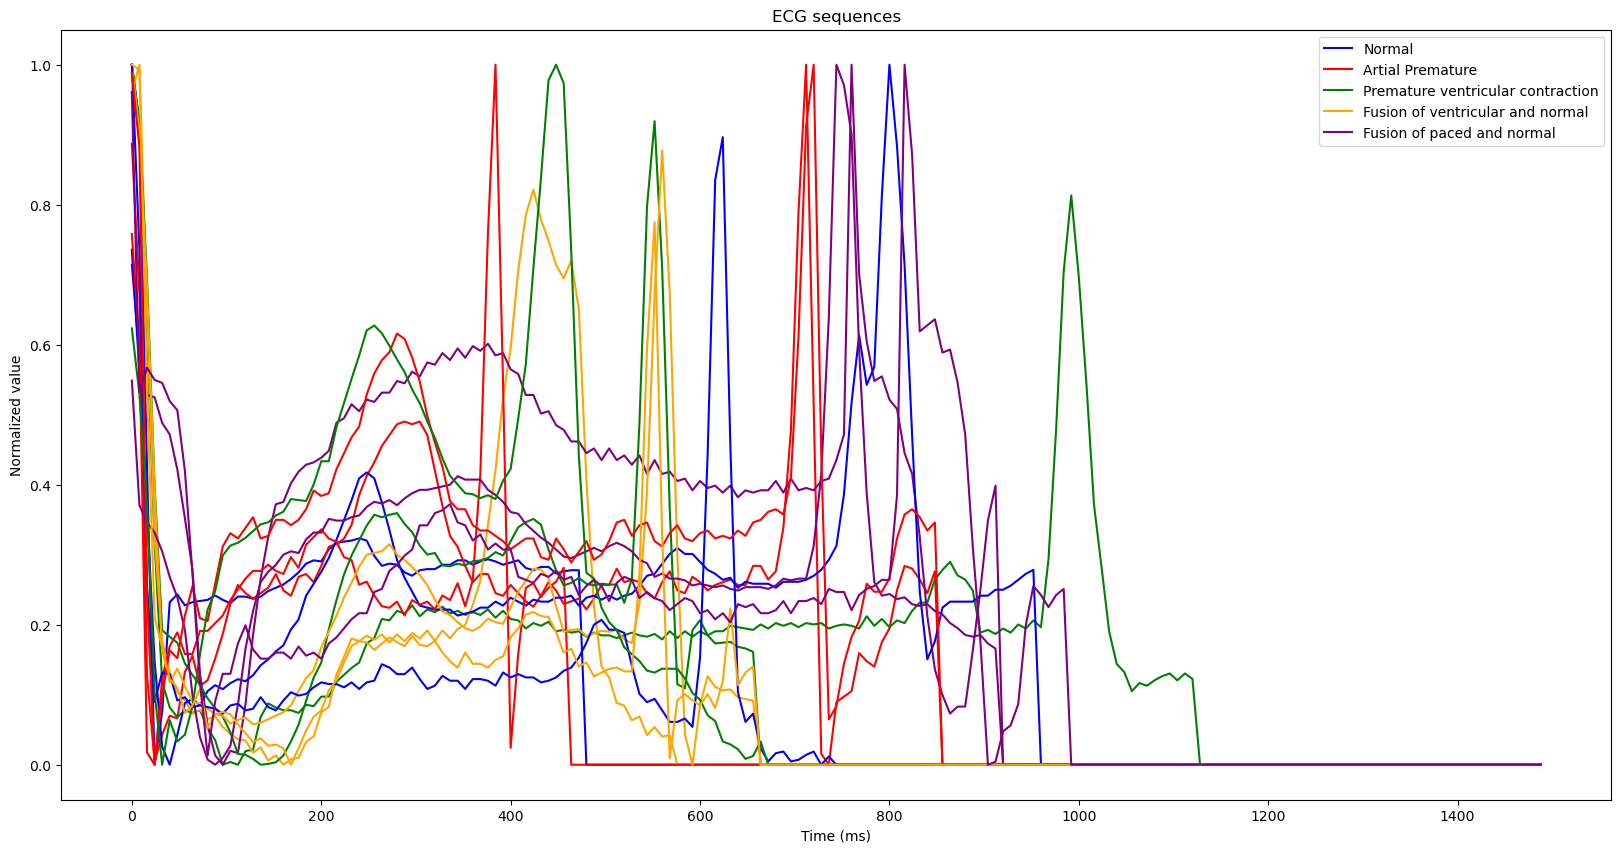

In [6]:
# create a figure
plt.figure(figsize = (20, 10))
# define colors for each class
colors = ["blue", "red", "green", "orange", "purple"]
# plot the normal sequences
for i in range(3):
    for label in id_to_label.keys():
        # sample a random sequence from that label
        df_mitbih_label = df_mitbih[df_mitbih["label"] == label].sample(1)
        # plot the sequence
        if i == 0:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], label = id_to_label[label], color = colors[label])
        else:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], color = colors[label])  
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [7]:
df_mitbih.head(10)

,0.0,8.0,16.0,24.0,32.0,40.0,48.0,56.0,64.0,72.0,...,1424.0,1432.0,1440.0,1448.0,1456.0,1464.0,1472.0,1480.0,1488.0,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.423611,0.791667,1.000000,0.256944,0.000000,0.277778,0.465278,0.520833,0.472222,0.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.716814,0.539823,0.283186,0.129794,0.064897,0.076696,0.026549,0.032448,0.008850,0.044248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.874214,0.849057,0.480084,0.058700,0.090147,0.310273,0.387841,0.385744,0.389937,0.392034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.000000,0.996086,0.694716,0.336595,0.238748,0.268102,0.191781,0.174168,0.164384,0.187867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Clustering

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Normalize all columns in the dataframe except for 'label'
columns_to_normalize = df_mitbih.columns.difference(['label'])

# Create a copy of the dataframe
df_normalized = df_mitbih.copy()

# Normalize the selected columns
scaler = MinMaxScaler()
df_normalized[columns_to_normalize] = scaler.fit_transform(df_mitbih[columns_to_normalize])

# View the normalized dataframe
df_normalized.head(10)

,0.0,8.0,16.0,24.0,32.0,40.0,48.0,56.0,64.0,72.0,...,1424.0,1432.0,1440.0,1448.0,1456.0,1464.0,1472.0,1480.0,1488.0,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.423611,0.791667,1.000000,0.256944,0.000000,0.277778,0.465278,0.520833,0.472222,0.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.716814,0.539823,0.283186,0.129794,0.064897,0.076696,0.026549,0.032448,0.008850,0.044248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.874214,0.849057,0.480084,0.058700,0.090147,0.310273,0.387841,0.385744,0.389937,0.392034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.000000,0.996086,0.694716,0.336595,0.238748,0.268102,0.191781,0.174168,0.164384,0.187867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
y = df_normalized['label'].copy()
X = df_normalized.drop('label', axis=1).copy()

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

In [10]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans

In [11]:
ECG_features = df_normalized.drop('label', axis=1)
ECG_labels = df_normalized['label']

In [12]:
kmeans_model = KMeans(n_clusters=5, max_iter=1000).fit(ECG_features)

/g/g11/mcnaught/.conda/envs/cso/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
ECG_test = df_normalized.sample(20, replace=False)

ECG_test_features = df_normalized.drop('label', axis=1)

ECG_test_labels = df_normalized['label']

In [14]:
pred_clusters = kmeans_model.predict(ECG_test_features)

In [15]:
pred_results = pd.DataFrame({'actual_class': ECG_test_labels, 
                             'pred_cluster': pred_clusters})

pred_results.head()

,actual_class,pred_cluster
0,0.0,1
1,0.0,1
2,0.0,1
3,0.0,1
4,0.0,1


In [16]:
print(len(pred_results['pred_cluster']))
print(len(pred_results['actual_class']))


109446
109446


In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# True labels
true_labels = pred_results['pred_cluster']

predicted_labels = pred_results['actual_class']

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='macro')
print("Precision:", precision)

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='macro')
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print("F1 Score:", f1)


Confusion Matrix:
[[ 3959    19   552     7     2]
 [46679   772  1605   583  1517]
 [ 4456   143  1510     6  4375]
 [22695  1177  1415   204   383]
 [12800   668  2154     3  1762]]
Accuracy: 0.0749867514573397
Precision: 0.20068165753437756
Recall: 0.22809614088516086
F1 Score: 0.08722516717969112


# T-SNE Clustering

In [18]:
from sklearn.manifold import TSNE

In [19]:
m = TSNE(learning_rate=50)

In [20]:
tsne_features = m.fit_transform(x_train)

tsne_features[1:4, :]

array([[-7.4043584 ,  1.3092124 ],
       [ 0.69316256, -1.5335282 ],
       [16.22003   , 29.475027  ]], dtype=float32)

In [21]:
x_train['x'] = tsne_features[:,0]
x_train['y'] = tsne_features[:,1]

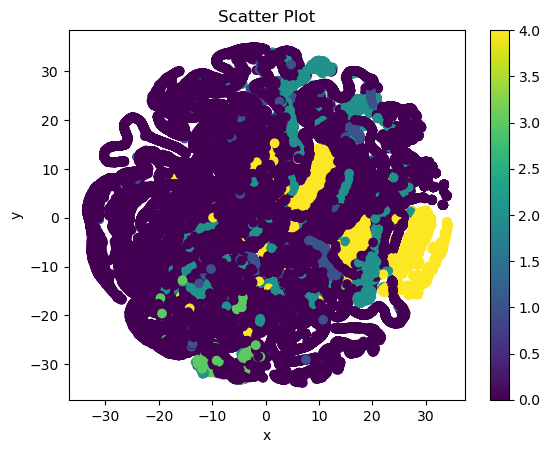

In [22]:
plt.scatter(x_train['x'], x_train['y'], c=y_train)

# Set the axis labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot')

plt.colorbar()
plt.show()

In [23]:
X = df_mitbih.drop('label', axis=1).values
y = df_mitbih['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
X_train.shape

(87556, 187)

In [25]:
num_classes = len(np.unique(y_train))

num_timesteps = X_train.shape[1]  # Assumes each column represents a timestep
num_features = 1  # Assumes a single feature per timestep

input_shape = (num_timesteps, num_features)


# Recurrent Neural Network

In [44]:
import tensorflow as tf
from tensorflow import keras

def make_rcnn_model(input_shape, num_classes):
    input_layer = keras.layers.Input(input_shape)

    # Convolutional layers
    conv1d = keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
    conv1d = keras.layers.MaxPooling1D(pool_size=2)(conv1d)
    conv1d = keras.layers.Dropout(0.2)(conv1d)

    # Recurrent layers
    rnn = keras.layers.Bidirectional(keras.layers.GRU(64, return_sequences=True))(conv1d)
    rnn = keras.layers.Dropout(0.2)(rnn)

    # Flatten layer
    flatten = keras.layers.Flatten()(rnn)

    # Dense layers
    dense = keras.layers.Dense(64, activation='relu')(flatten)
    output_layer = keras.layers.Dense(num_classes, activation='softmax')(dense)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Create the RCNN model
model = make_rcnn_model(input_shape, num_classes)


2023-06-12 11:05:09.868877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 11:05:09.871748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 11:05:09.873686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

# Results

In [49]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

685/685 [==============================] - 14s 21ms/step - loss: 0.1123 - accuracy: 0.9859
Test accuracy 0.9859296679496765
Test loss 0.11232361197471619


In [48]:
# Loads the weights
checkpoint_path = "cp.ckpt"
model.load_weights(checkpoint_path)


In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

# Xtreme Gradient Boosting (XGBOOST)

In [29]:
model_xgboost = xgboost.XGBClassifier(learning_rate=0.1,
                                      max_depth=5,
                                      n_estimators=5000,
                                      subsample=0.5,
                                      colsample_bytree=0.5,
                                      eval_metric='auc',
                                      verbosity=1)

eval_set = [(X_test, y_test)]

model_xgboost.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=eval_set,
                  verbose=True)



/g/g11/mcnaught/.conda/envs/cso/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.93407
[1]	validation_0-auc:0.94544
[2]	validation_0-auc:0.95287
[3]	validation_0-auc:0.95536
[4]	validation_0-auc:0.95659
[5]	validation_0-auc:0.95712
[6]	validation_0-auc:0.95836
[7]	validation_0-auc:0.95911
[8]	validation_0-auc:0.96052
[9]	validation_0-auc:0.96153
[10]	validation_0-auc:0.96155
[11]	validation_0-auc:0.96219
[12]	validation_0-auc:0.96396
[13]	validation_0-auc:0.96404
[14]	validation_0-auc:0.96524
[15]	validation_0-auc:0.96646
[16]	validation_0-auc:0.96741
[17]	validation_0-auc:0.96771
[18]	validation_0-auc:0.96832
[19]	validation_0-auc:0.96892
[20]	validation_0-auc:0.97011
[21]	validation_0-auc:0.97067
[22]	validation_0-auc:0.97176
[23]	validation_0-auc:0.97246
[24]	validation_0-auc:0.97299
[25]	validation_0-auc:0.97401
[26]	validation_0-auc:0.97484
[27]	validation_0-auc:0.97500
[28]	validation_0-auc:0.97527
[29]	validation_0-auc:0.97591
[30]	validation_0-auc:0.97649
[31]	validation_0-auc:0.97682
[32]	validation_0-auc:0.97709
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=5000, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

# Results

In [30]:
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

# Predict probabilities on the training and test sets
y_train_pred_proba = model_xgboost.predict_proba(X_train)
y_test_pred_proba = model_xgboost.predict_proba(X_test)

# Calculate the AUC for each class
auc_scores_train = []
auc_scores_test = []
for class_idx in range(5):
    y_train_true_class = np.where(y_train == class_idx, 1, 0)
    y_test_true_class = np.where(y_test == class_idx, 1, 0)
    
    y_train_pred_class = y_train_pred_proba[:, class_idx]
    y_test_pred_class = y_test_pred_proba[:, class_idx]
    
    auc_scores_train.append(roc_auc_score(y_train_true_class, y_train_pred_class))
    auc_scores_test.append(roc_auc_score(y_test_true_class, y_test_pred_class))

# Calculate the average AUC
auc_mean_train = np.mean(auc_scores_train)
auc_mean_test = np.mean(auc_scores_test)

# Calculate the accuracy
y_train_pred = np.argmax(y_train_pred_proba, axis=1)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print("Mean AUC Train: {:.4f}".format(auc_mean_train))
print("Mean AUC Test: {:.4f}".format(auc_mean_test))
print("Accuracy Train: {:.4f}".format(accuracy_train))
print("Accuracy Test: {:.4f}".format(accuracy_test))

Mean AUC Train: 0.9999
Mean AUC Test: 0.9927
Accuracy Train: 0.9951
Accuracy Test: 0.9805


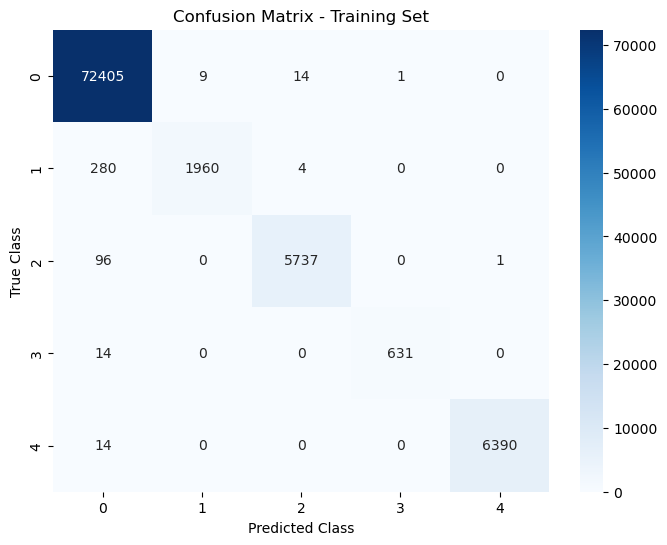

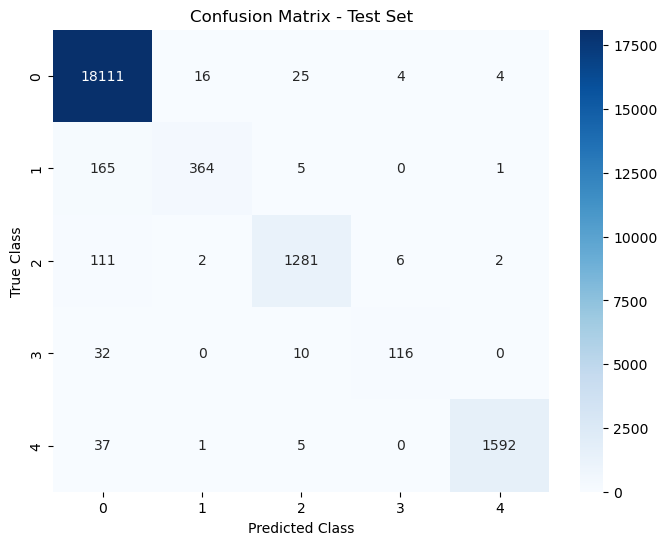

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
confusion_train = confusion_matrix(y_train, y_train_pred)
confusion_test = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_train, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Plot the confusion matrix for test set
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

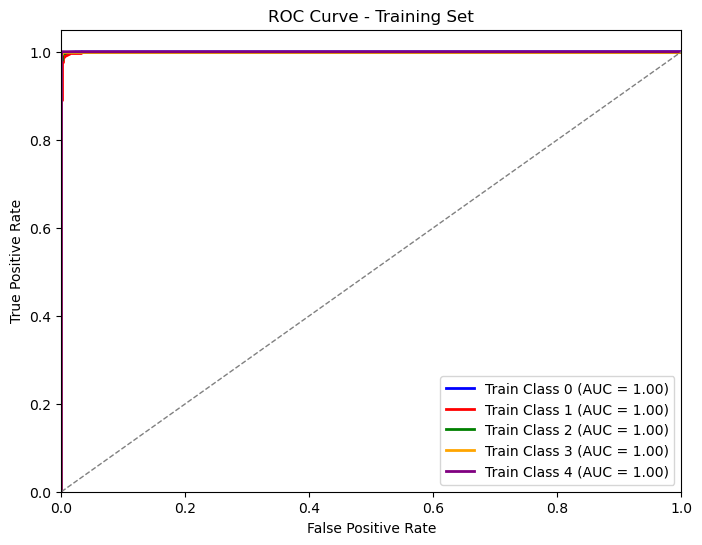

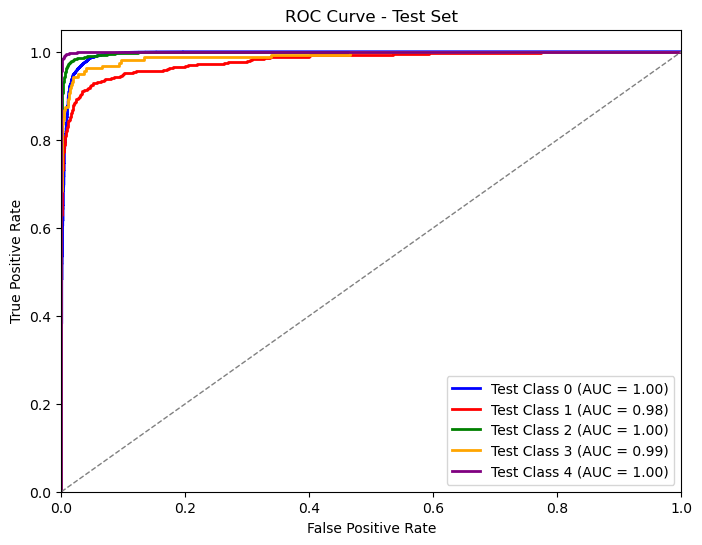

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve and AUC for each class
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()

for class_idx in range(5):
    fpr_train[class_idx], tpr_train[class_idx], _ = roc_curve(
        np.where(y_train == class_idx, 1, 0), y_train_pred_proba[:, class_idx])
    roc_auc_train[class_idx] = auc(fpr_train[class_idx], tpr_train[class_idx])

    fpr_test[class_idx], tpr_test[class_idx], _ = roc_curve(
        np.where(y_test == class_idx, 1, 0), y_test_pred_proba[:, class_idx])
    roc_auc_test[class_idx] = auc(fpr_test[class_idx], tpr_test[class_idx])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for class_idx in range(5):
    plt.plot(fpr_train[class_idx], tpr_train[class_idx],
             color=colors[class_idx], lw=2,
             label='Train Class {} (AUC = {:.2f})'.format(class_idx, roc_auc_train[class_idx]))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(8, 6))
for class_idx in range(5):
    plt.plot(fpr_test[class_idx], tpr_test[class_idx],
             color=colors[class_idx], lw=2,
             label='Test Class {} (AUC = {:.2f})'.format(class_idx, roc_auc_test[class_idx]))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")
plt.show()